# Correlation measurement for errors of worker

AMT data, "intervention" criteria

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

In [2]:
data = pd.read_csv('../output/amt_data/crowd-data.csv')

In [3]:
data

,paper ID,intervention worker ID,intervention Vote,is intervention vote accurate?,use of tech paper ID,use of tech worker ID,use of tech vote,is tech vote accurate?,older adult paper ID,older adult worker ID,older adult vote,is older vote accurate?,Unnamed: 12,classes,GOLD INTERVENTION,GOLD USE OF TECH,GOLD OLD,GOLD SI,GOLD remote
0,1,AT6KZZ2OTABWK,1,1,1.0,AB66CTVQ90RCV,-1.0,0.0,1.0,A110KENBXU7SUJ,1.0,1.0,NaN,INCLUDED,1.0,1.0,1.0,1.0,1.0
1,1,A3IC61LDXYISDY,1,1,1.0,A1665VCUSZL9YT,1.0,1.0,1.0,A142ZRU284W9O,1.0,1.0,NaN,INCLUDED,1.0,1.0,1.0,1.0,1.0
2,1,A142ZRU284W9O,1,1,1.0,A1UE726OT3JLZ9,1.0,1.0,1.0,A3QX9ABC1DVMQG,-1.0,0.0,NaN,INCLUDED,1.0,1.0,1.0,1.0,1.0
3,1,APQMFEY1KUL6A,1,1,1.0,A2PZDX8PIK73K3,1.0,1.0,1.0,AT6KZZ2OTABWK,1.0,1.0,NaN,INCLUDED,1.0,1.0,1.0,1.0,1.0
4,1,A110KENBXU7SUJ,1,1,1.0,A3F9N2P4NUUR7S,-1.0,0.0,1.0,A1RO22O88I71FD,-1.0,0.0,NaN,INCLUDED,1.0,1.0,1.0,1.0,1.0
5,2,A31681CCEVDIH3,-1,0,2.0,A2PZDX8PIK73K3,1.0,1.0,2.0,A1JGZD9FUDYJ30,1.0,1.0,NaN,INCLUDED,1.0,1.0,1.0,1.0,1.0
6,2,A1UE726OT3JLZ9,-1,0,2.0,AB66CTVQ90RCV,-1.0,0.0,2.0,ASKV5KO5CV616,1.0,1.0,NaN,INCLUDED,1.0,1.0,1.0,1.0,1.0
7,2,AT6KZZ2OTABWK,1,1,2.0,A36ABFLSNFESVJ,1.0,1.0,2.0,A1F8ZAE0P2RA8O,-1.0,0.0,NaN,INCLUDED,1.0,1.0,1.0,1.0,1.0
8,2,AB66CTVQ90RCV,-1,0,2.0,A142ZRU284W9O,1.0,1.0,2.0,A1RO22O88I71FD,1.0,1.0,NaN,INCLUDED,1.0,1.0,1.0,1.0,1.0
9,2,A2SBISQJE2ZPJQ,-1,0,2.0,A3F9N2P4NUUR7S,-1.0,0.0,2.0,MISSING,1.0,1.0,NaN,INCLUDED,1.0,1.0,1.0,1.0,1.0


## Criteria setup

In [4]:
criteria = "intervention"

## Transform data

In [5]:
data["{} worker ID".format(criteria)].unique().size

105

In [6]:
data["paper ID"].unique().size

100

In [7]:
items_id_dict = dict(zip(data["paper ID"].unique(), list(range(100))))

In [8]:
vote_matrix = np.full(shape=(105, 100), fill_value = 0)

In [9]:
for worker_id, worker_name in enumerate(data["{} worker ID".format(criteria)].unique()):
    worker_votes = data[data["{} worker ID".format(criteria)] == worker_name]
    for index, row in worker_votes.iterrows():
        val = row["is {} vote accurate?".format(criteria)]
        val = val if val == 1 else -1
        vote_matrix[worker_id, items_id_dict[row['paper ID']]] = val
    

## Plot distribution of votes on the criteria

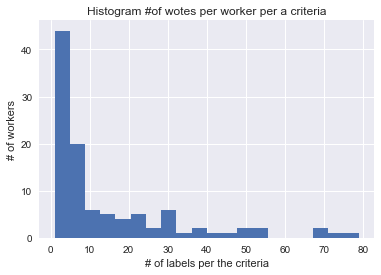

In [10]:
plt.hist(np.count_nonzero(vote_matrix, axis=1), bins=20);
plt.title("Histogram #of wotes per worker per a criteria");
plt.xlabel("# of labels per the criteria");
plt.ylabel("# of workers");

## Clean Data and Compute Kappa Statistics

In [11]:
# iterate over matrix of votes
# delete workers with less than 15 votes
rows_to_delete = []
for row_id, row in enumerate(vote_matrix):
    if np.count_nonzero(vote_matrix[row_id,]) < 10:
        rows_to_delete.append(row_id)
        
vote_matrix = np.delete(vote_matrix, rows_to_delete, 0)

In [12]:
corr_votes_data = [[] for _ in range(vote_matrix.shape[0])]

In [13]:
for pair in itertools.product(list(range(vote_matrix.shape[0])), repeat=2):
    worker_index = pair[0]
    worker_pair = pair[1]
    if worker_index == worker_pair:
        continue
    a, b, c, d = 0., 0., 0., 0.
    for i, j in vote_matrix[[worker_index, worker_pair], ].T:
        if i == j and i == 0:
            continue
        if i == j == 1:
            a += 1
        elif i == 1 and j == -1:
            b += 1
        elif i == -1 and j == 1:
            c += 1
        else:
            d += 1
    # if at least workers have 10 items being labeled by both workers
    if a + b + c + d < 10 or ((a+b)*(b+d) + (a+c)*(c+d)) == 0:
        continue
    kappa = 2*(a*d - b*c) / ((a+b)*(b+d) + (a+c)*(c+d))
    corr_votes_data[worker_index].append(kappa)

In [14]:
corr_workers_avg = [np.mean(corr) for corr in corr_votes_data]

In [15]:
df = pd.DataFrame(corr_workers_avg, columns=['kappa_avg'])
df.index.name = 'worker_id'
df

,kappa_avg
worker_id,
0,0.497246
1,0.517323
2,0.521251
3,0.468905
4,0.324365
5,0.355056
6,0.388737
7,0.431514
8,0.485088


In [16]:
# criteria kappa avg
np.mean(corr_workers_avg)

0.42636164562009765

## kappa avg for the criteria = 0.426